In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
def filling_missed(df):
  df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
  df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
  import numpy as np

  df = df.replace(r'^\s*$', np.nan, regex=True)
  num_cols = df.select_dtypes(include=np.number).columns
  df[num_cols] = df[num_cols].fillna(df[num_cols].median())

  cat_cols = df.select_dtypes(include='object').columns
  df[cat_cols] = df[cat_cols].apply(lambda col: col.fillna(col.mode()[0]))

  return df


def classifying(df):
  classing = ['gender', 'Dependents', 'Partner', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'PaymentMethod', 'Churn']
  for each in classing:
    if each in df.columns:
      df[each] = df[each].astype('category').cat.codes
  return df

In [ ]:
df = classifying(filling_missed(df))

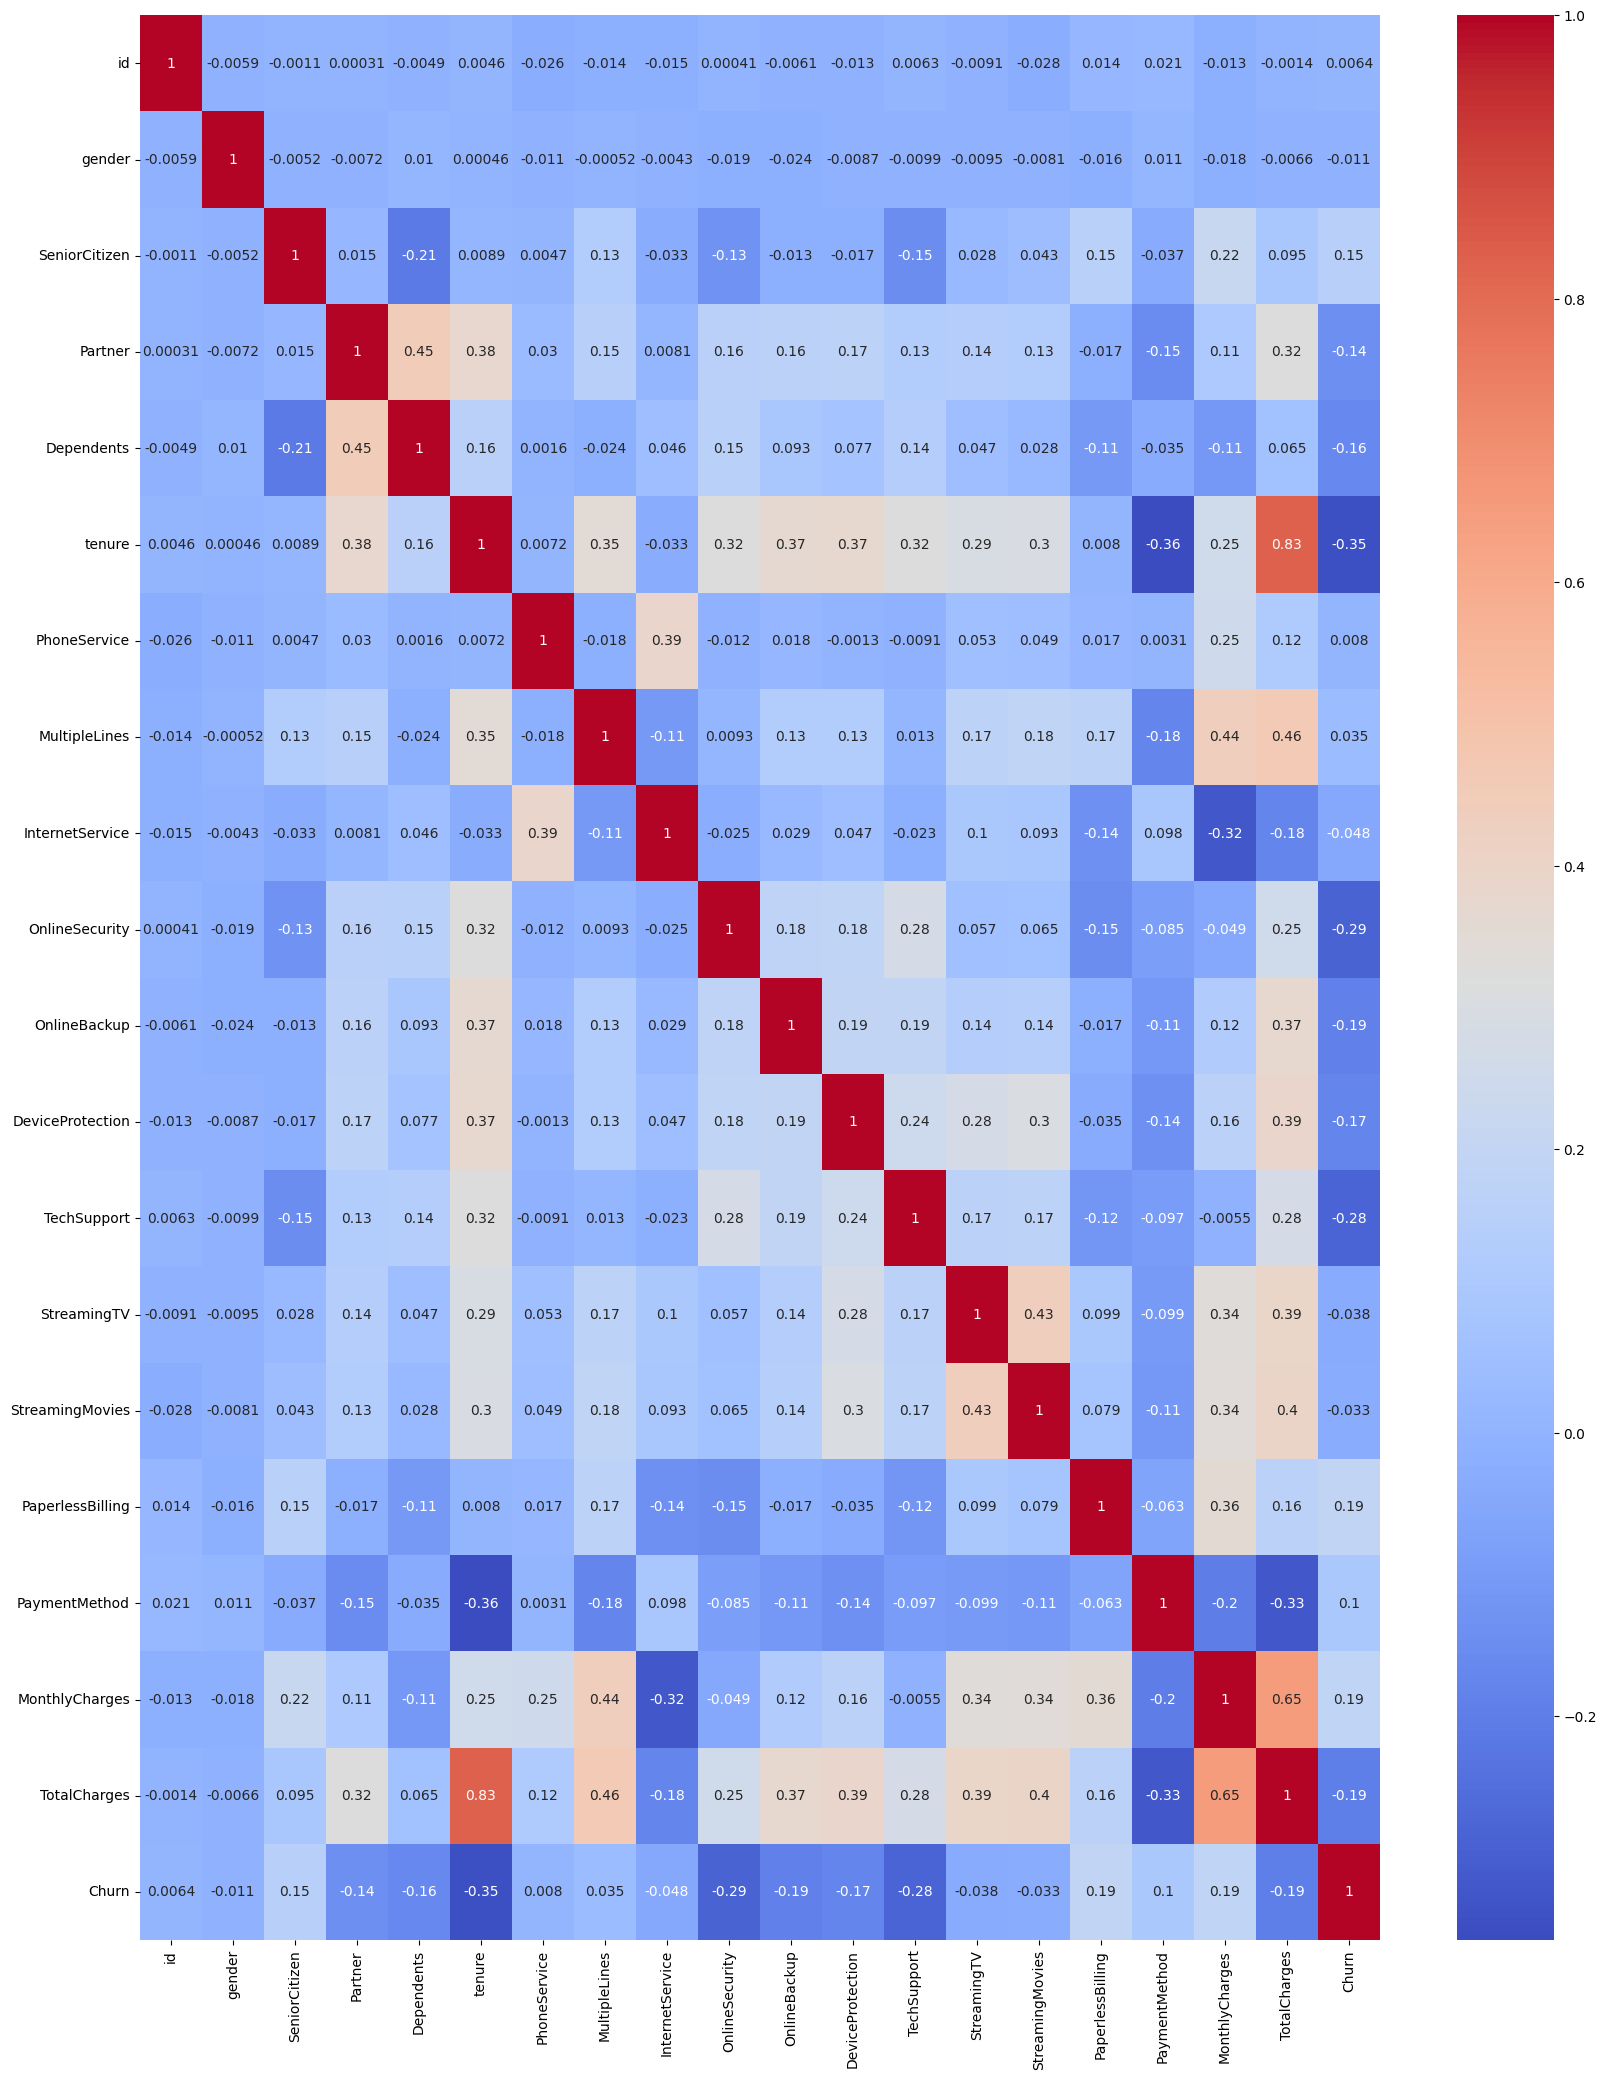

In [ ]:
plt.figure(figsize=(20,25))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "n_estimators": [100, 300],       # fewer options
    "max_depth": [None, 20],          # shallow vs deep
    "min_samples_split": [2, 5],      # typical values
    "min_samples_leaf": [1, 2],       # small set
    "max_features": ["sqrt", "log2"], # drop the float
    "bootstrap": [True],              # keep one option
    "class_weight": ["balanced"]      # assume imbalance
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=skf,
    n_jobs=-1,
    verbose=1
)

grid.fit(x_train, y_train)

print("Best weighted-F1 (CV):", grid.best_score_)
print("Best params:", grid.best_params_)

best_model = grid.best_estimator_


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best weighted-F1 (CV): 0.7816628700788947
Best params: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
y_pred = best_model.predict(x_test)

def custom_points(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    if f1 < 0.50:
        return 0, f1
    points = 100 * (f1 - 0.50) / 0.50
    return points, f1

# Example usage
points, f1 = custom_points(y_test, y_pred)
print(f"F1-score = {f1:.3f}, Points = {points:.1f}")

F1-score = 0.647, Points = 29.4


In [ ]:
test_df = pd.read_csv('test.csv')

test_df = classifying(filling_missed(test_df))
final_pred = best_model.predict(test_df)

In [ ]:
results = pd.DataFrame({
    "id": test_df["id"],   # or df['id'] if you have an 'id' column
    "Churn": pd.Series(final_pred).map({1: "Yes", 0: "No"})
})

name = 'new.csv'

results.to_csv(name, index=False)
print(f"Saved to {name}")

Saved to new.csv
